## 환경설정 및 라이브러리 설치
필요한 라이브러리 설치
(유튜브 스크립트를 가져오기 위한 youtube-transcript-api와 pytube 추가)

In [2]:
pip install langchain langchain-openai langgraph youtube-transcript-api faiss-cpu pytube yt-dlp soundfile faster-whisper

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import os
import io
import subprocess
from typing import List, TypedDict, Literal
from datetime import datetime

# --- LangChain 및 관련 라이브러리 임포트 ---
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, START, END
from langchain import hub

# --- 음성 인식 및 자막 처리 라이브러리 임포트 ---
from youtube_transcript_api import YouTubeTranscriptApi
from faster_whisper import WhisperModel
import soundfile as sf
from urllib.parse import urlparse, parse_qs

In [23]:
from dotenv import load_dotenv
load_dotenv()

True

## Agent State 정의

In [24]:
class YoutubeAgentState(TypedDict):
    youtube_url: str            # 입력받을 유튜브 URL
    query: str                  # 사용자의 질문 또는 요약 요청
    transcript: List[Document]  # 스크립트를 분할하여 저장할 리스트
    context: List[Document]     # RAG를 위해 검색된 스크립트 조각
    summary: str                # 최종 생성된 요약문
    error: str                  # 오류 발생 시 메시지
    transcript_type: str

## 노드 정의

In [25]:
def get_video_id(url: str) -> str:
    """다양한 형태의 유튜브 URL에서 비디오 ID를 추출합니다."""
    if "youtu.be" in url:
        return url.split("/")[-1].split("?")[0]
    if "youtube.com" in url:
        query = parse_qs(urlparse(url).query)
        if "v" in query:
            return query["v"][0]
    return None

### 라우터 노드

In [26]:
def check_transcript_type_node(state: YoutubeAgentState) -> dict:
    """
    yt-dlp를 직접 호출하여 영상의 자막 리스트를 '더 엄격하게' 확인하고,
    그 결과를 상태('transcript_type')에 저장합니다.
    """
    url = state['youtube_url']
    print("="*50)
    print(f"1. [진단] yt-dlp를 사용해 '{url}' 영상의 자막 유형 확인을 시작합니다.")
    command = ["yt-dlp", "--list-subs", "--cookies", "cookies.txt", url]
    decision = "whisper"
    try:
        # check=True를 빼서 오류가 나도 프로세스가 죽지 않게 함
        result = subprocess.run(command, capture_output=True, text=True, encoding='utf-8')
        output = result.stdout

        # --- 이 부분이 수정됩니다 ---
        # 'auto-generated'가 없고, 언어 코드가 단순한 'en' 또는 'ko'인 경우를 찾습니다.
        is_manual_found = False
        for line in output.split('\n'):
            # 예: 'en' 또는 'ko' 로 시작하고, 다른 복잡한 이름이 없는 라인
            if line.strip().startswith('en ') or line.strip().startswith('ko '):
                if 'auto-generated' not in line:
                    print(f"--> [진단 결과] 수동 자막 가능성 높음! 'manual' 경로를 선택합니다. ({line.strip()})")
                    decision = "manual"
                    is_manual_found = True
                    break

        if not is_manual_found:
             print("--> [진단 결과] 수동 자막이 없거나 자동 번역 자막만 있습니다. 'whisper' 경로를 선택합니다.")

    except Exception as e:
        print(f"자막 종류 확인 중 예기치 않은 오류 발생: {e}")

    print("="*50)
    return {"transcript_type": decision}

In [27]:
def decide_transcript_path(state: YoutubeAgentState) -> Literal["manual", "whisper"]:
    """
    상태에 저장된 transcript_type 값을 읽어 경로를 결정합니다.
    이 함수는 check_transcript_type_node가 상태에 저장한 값을 읽어 사용합니다.
    """
    return state["transcript_type"]

# 이 함수는 바로 다음의 for 루프에서 사용됩니다.
def decide_after_source(state: YoutubeAgentState):
    """텍스트 추출 후 에러 여부에 따라 경로를 결정합니다."""
    return "error" if state.get("error") else "continue"

### 수동 자막 추출 노드

In [28]:
def get_manual_transcript(state: YoutubeAgentState) -> YoutubeAgentState:
    """수동 자막을 가져오되, 처리할 텍스트의 양을 제한합니다."""
    print(">>> 경로 선택: '빠른 경로(get_manual_transcript)' 노드가 성공적으로 실행되었습니다! <<<")
    url = state['youtube_url']
    video_id = get_video_id(url)
    try:
        transcript_data = YouTubeTranscriptApi.get_transcript(video_id, languages=['ko', 'en'], cookies='cookies.txt')
        full_transcript = " ".join([chunk['text'] for chunk in transcript_data])

        # --- 이 부분이 추가됩니다 ---
        # 처리할 최대 글자 수를 30000자로 제한 (약 10~15분 분량)
        max_chars = 30000
        truncated_transcript = full_transcript[:max_chars]
        print(f"--- 원본 텍스트 길이: {len(full_transcript)}, 처리할 텍스트 길이: {len(truncated_transcript)} ---")

        # 잘라낸 텍스트로 Document를 생성합니다.
        doc = Document(page_content=truncated_transcript, metadata={"source": url, "truncated": True})
        # --------------------------

        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
        split_docs = text_splitter.split_documents([doc])

        return {"transcript": split_docs}
    except Exception as e:
        return {"error": f"수동 자막을 가져오는 중 오류 발생: {e}"}

### whisper노드

In [29]:
def transcribe_audio_in_chunks(state: YoutubeAgentState) -> YoutubeAgentState:
    """
    오디오 스트림을 청크 단위로 실시간 처리하여 메모리 사용량을 최소화합니다.
    """
    url = state['youtube_url']
    duration_to_process = 300  # 처리할 총 시간(초)
    chunk_duration_seconds = 30 # 한 번에 처리할 청크 크기(초)
    
    # 오디오 속성: 16kHz, 16-bit, 모노 채널
    SAMPLE_RATE = 16000
    BYTES_PER_SAMPLE = 2 # 16-bit = 2 bytes
    CHANNELS = 1
    
    # 30초 분량의 오디오 데이터 크기 (바이트 단위)
    CHUNK_SIZE = SAMPLE_RATE * BYTES_PER_SAMPLE * CHANNELS * chunk_duration_seconds

    print("--- [최적화 경로] 청크 단위 음성 인식 시작 ---")
    
    try:
        # 1. Whisper 모델을 미리 로드합니다.
        print("--- Whisper 모델('base') 로드 중... ---")
        model = WhisperModel("base", device="cpu", compute_type="int8")

        # 2. yt-dlp와 ffmpeg 프로세스를 시작합니다.
        ytdlp_cmd = ["yt-dlp", "-f", "bestaudio", "-o", "-", url]
        ffmpeg_cmd = [
            "ffmpeg", "-i", "pipe:0", "-t", str(duration_to_process), 
            "-f", "s16le", "-acodec", "pcm_s16le", "-ar", str(SAMPLE_RATE), "-ac", str(CHANNELS), "pipe:1"
        ]
        
        ytdlp_proc = subprocess.Popen(ytdlp_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        ffmpeg_proc = subprocess.Popen(ffmpeg_cmd, stdin=ytdlp_proc.stdout, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        ytdlp_proc.stdout.close()

        # 3. 오디오 스트림을 청크 단위로 읽고 처리하는 루프
        full_transcript = []
        total_processed_seconds = 0
        
        while True:
            # 파이프로부터 정해진 크기만큼의 오디오 데이터를 읽습니다.
            audio_chunk_bytes = ffmpeg_proc.stdout.read(CHUNK_SIZE)
            
            # 더 이상 읽을 데이터가 없으면 루프를 종료합니다.
            if not audio_chunk_bytes:
                break
            
            total_processed_seconds += chunk_duration_seconds
            print(f"--- {min(total_processed_seconds, duration_to_process)}초 분량 처리 중... ---")

            # 바이트 데이터를 float32 Numpy 배열로 변환합니다.
            audio_chunk_np = np.frombuffer(audio_chunk_bytes, dtype=np.int16).astype(np.float32) / 32768.0

            # 한 조각(청크)을 음성 인식합니다.
            segments, _ = model.transcribe(audio_chunk_np, beam_size=5, language="ko")
            text_chunk = "".join(segment.text for segment in segments)
            full_transcript.append(text_chunk)

        # 모든 조각의 텍스트를 하나로 합칩니다.
        final_text = "".join(full_transcript)
        print("--- 음성 인식 완료 ---")

        # 프로세스가 모두 종료될 때까지 기다립니다.
        ffmpeg_proc.wait()
        ytdlp_proc.wait()

        # 4. LangChain Document 형식으로 변환합니다.
        doc = Document(page_content=final_text, metadata={"source": url})
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
        split_docs = text_splitter.split_documents([doc])
        
        return {"transcript": split_docs}

    except Exception as e:
        return {"error": f"오디오 청크 처리 중 오류 발생: {e}"}

### RAG노드

In [30]:
def create_db_and_retrieve_context(state: YoutubeAgentState) -> YoutubeAgentState:
    """FAISS VectorDB를 생성하고, 사용자 질문과 관련된 문서를 검색합니다."""
    print("--- 텍스트 벡터화 및 핵심 내용 검색 시작 ---")
    if state.get("error"): return {}
    try:
        # --- 모델 이름을 'large'에서 'small'로 변경 ---
        embedding = OpenAIEmbeddings(model="text-embedding-3-small")

        vector_store = FAISS.from_documents(documents=state['transcript'], embedding=embedding)
        retriever = vector_store.as_retriever(search_kwargs={"k": 5})
        retrieved_docs = retriever.invoke(state['query'])
        return {"context": retrieved_docs}
    except Exception as e:
        return {"error": f"VectorDB 생성 또는 검색 중 오류 발생: {e}"}

### Self-Correction노드

### 스크립트 get and split 노드

In [31]:
# import subprocess
# import io
# from faster_whisper import WhisperModel # faster-whisper 임포트
# import numpy as np
# import soundfile as sf
# from langchain_core.documents import Document
# from langchain_text_splitters import RecursiveCharacterTextSplitter

# # 제안해주신 코드를 함수로 만듭니다.
# def download_audio_pipe(video_url: str) -> bytes:
#     """yt-dlp와 ffmpeg 파이프를 사용해 오디오를 다운로드하고 wav 바이트로 변환합니다."""
#     ytdlp_cmd = ["yt-dlp", "-f", "bestaudio", "-o", "-", video_url]
#     ffmpeg_cmd = [
#         "ffmpeg", "-i", "pipe:0", "-f", "wav", "-acodec", "pcm_s16le",
#         "-ar", "16000", "-ac", "1", "pipe:1"
#     ]
    
#     ytdlp_proc = subprocess.Popen(ytdlp_cmd, stdout=subprocess.PIPE)
#     ffmpeg_proc = subprocess.Popen(ffmpeg_cmd, stdin=ytdlp_proc.stdout, stdout=subprocess.PIPE)
#     ytdlp_proc.stdout.close() # ytdlp의 출력을 ffmpeg으로만 보내도록 파이프를 닫습니다.

#     audio_bytes = ffmpeg_proc.stdout.read()
#     ffmpeg_proc.stdout.close()
#     ffmpeg_proc.wait()
#     ytdlp_proc.wait()
    
#     return audio_bytes

# # 에이전트의 새로운 노드가 될 함수입니다.
# def transcribe_with_whisper_pipe(state: YoutubeAgentState) -> YoutubeAgentState:
#     """
#     URL에서 오디오를 스트리밍하고 'faster-whisper'로 변환하여 Document 리스트로 만듭니다.
#     """
#     url = state['youtube_url']
#     print("--- 1. 오디오 다운로드 및 변환 시작 ---")

#     try:
#         audio_bytes = download_audio_pipe(url)
#         audio_buffer = io.BytesIO(audio_bytes)
#         audio_np, sr = sf.read(audio_buffer)
#         audio_np = audio_np.astype('float32')

#         # --- 이 부분이 변경됩니다 ---
#         print("--- 3. faster-whisper 모델 로드 및 음성 인식 시작 ---")
#         # model_size = "base" 또는 "tiny", "small", "medium"
#         model = WhisperModel("base", device="cpu", compute_type="int8")

#         # transcribe 메서드는 제너레이터를 반환합니다.
#         segments, info = model.transcribe(audio_np, beam_size=5, language="ko")

#         print(f"감지된 언어: '{info.language}' (신뢰도: {info.language_probability})")

#         # 전체 텍스트를 하나로 합칩니다.
#         full_transcript = "".join(segment.text for segment in segments)
#         print("--- 4. 음성 인식 완료 ---")

#         # ... (이하 LangChain Document로 변환하는 부분은 동일) ...
#         doc = Document(page_content=full_transcript, metadata={"source": url})
#         text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
#         split_docs = text_splitter.split_documents([doc])

#         return {"transcript": split_docs}

#     except Exception as e:
#         print(f"스크립트 변환 중 오류 발생: {e}")
#         return {"error": "스크립트 변환 과정에서 오류가 발생했습니다."}

### vectorDB 생성, Retrieve 노드

In [32]:
# from langchain_openai import OpenAIEmbeddings
# from langchain_community.vectorstores import FAISS

# def create_db_and_retrieve_context(state: YoutubeAgentState) -> YoutubeAgentState:
#     """
#     FAISS VectorDB를 생성하고, 사용자 질문과 관련된 스크립트 조각을 검색합니다.
#     """
#     if state.get("error"): # 이전 단계에서 오류가 발생했다면 실행하지 않음
#         return {}

#     query = state['query']
#     docs = state['transcript']
#     embedding = OpenAIEmbeddings(model="text-embedding-3-large")
    
#     try:
#         vector_store = FAISS.from_documents(
#             documents=docs,
#             embedding=embedding
#         )
        
#         # Retriever 생성
#         retriever = vector_store.as_retriever(search_kwargs={"k": 5})
        
#         # 관련 문서 검색
#         retrieved_docs = retriever.invoke(query)
        
#         return {"context": retrieved_docs}
#     except Exception as e:
#         print(f"Error creating VectorDB or retrieving context: {e}")
#         return {"error": "VectorDB 생성 또는 검색 중 오류가 발생했습니다."}

### 요약 생성 노드

In [33]:
from langchain_openai import ChatOpenAI
from langchain import hub

# LLM 선언
llm = ChatOpenAI(model='gpt-4o-mini')
generate_prompt = hub.pull('rlm/rag-prompt')

def generate_summary(state: YoutubeAgentState) -> YoutubeAgentState:
    """
    검색된 문맥을 바탕으로 요약문을 생성합니다.
    """
    if state.get("error"):
        return {}
        
    context = state['context']
    query = state['query']

    rag_chain = generate_prompt | llm

    response = rag_chain.invoke({"question": query, "context": context})

    return {'summary': response.content}

### 품질 평가 노드 (self-rag)

In [34]:
# from langchain_core.prompts import PromptTemplate
# from langchain_core.output_parsers import StrOutputParser
# from typing import Literal

#### 환각 평가

In [35]:
def check_hallucination(state: YoutubeAgentState) -> Literal['hallucinated', 'not hallucinated']:
    """생성된 요약이 원본 스크립트에 기반했는지 평가합니다."""
    print("--- 환각(Hallucination) 평가 시작 ---")
    summary = state['summary']
    context_docs = state['context']
    
    hallucination_prompt = PromptTemplate.from_template(
        "You are an evaluator. Your task is to check if the student's summary is based on the provided transcript excerpts.\n"
        "If the summary is consistent with the transcript, respond with 'not hallucinated'.\n"
        "If the summary contains information not present in the transcript, respond with 'hallucinated'.\n\n"
        "Transcript: {documents}\nSummary: {student_answer}"
    )
    hallucination_chain = hallucination_prompt | llm | StrOutputParser()
    response = hallucination_chain.invoke({'student_answer': summary, 'documents': context_docs})
    
    if "not hallucinated" in response.lower():
        print("--> 평가: 환각 없음 (not hallucinated)")
        return 'not hallucinated'
    else:
        print("--> 평가: 환각 의심 (hallucinated)")
        return 'hallucinated'

#### 유용성 평가

In [36]:
def check_helpfulness_node(state: YoutubeAgentState) -> YoutubeAgentState:
    """그래프 가독성을 위한 유용성 평가 진입점 노드 (상태 변경 없음)"""
    return state

def check_helpfulness_grader(state: YoutubeAgentState) -> Literal['helpful', 'unhelpful']:
    """생성된 요약이 사용자 질문에 유용한 답변인지 평가합니다."""
    print("--- 유용성(Helpfulness) 평가 시작 ---")
    query = state['query']
    summary = state['summary']
    
    helpfulness_prompt = hub.pull('langchain-ai/rag-answer-helpfulness')
    helpfulness_chain = helpfulness_prompt | llm
    response = helpfulness_chain.invoke({'question': query, 'student_answer': summary})
    
    if response.get('Score') == 1:
        print('--> 평가: 유용함 (helpful)')
        return 'helpful'
    else:
        print('--> 평가: 유용하지 않음 (unhelpful)')
        return 'unhelpful'

#### 질문 재작성

In [37]:
def rewrite_query(state: YoutubeAgentState) -> YoutubeAgentState:
    """사용자의 질문을 더 효과적인 형태로 재작성합니다."""
    print("--- 질문 재작성 시작 ---")
    query = state['query']
    
    rewrite_prompt = PromptTemplate.from_template(
        "You are a query rewriting expert. Rephrase the user's question to be more specific and likely to yield a better answer from a video transcript.\n"
        "For example, 'summarize this' could become 'What are the key takeaways and main arguments of this video?'.\n"
        "Original Question: {query}\nRewritten Question:"
    )
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    new_query = rewrite_chain.invoke({'query': query})
    print(f"--> 새로운 질문: {new_query}")
    
    return {'query': new_query}

## 그래프 구성

In [38]:
# ==============================================================================
# 2. 에이전트 그래프(Graph) 구성
# ==============================================================================

# 그래프의 상태(State)로 YoutubeAgentState를 사용하도록 빌더를 초기화합니다.
graph_builder = StateGraph(YoutubeAgentState)

# --- 2-1. 모든 노드(Node)들을 그래프에 추가 ---
# 각 노드는 에이전트가 수행하는 '작업' 단위입니다.

# 텍스트 추출 경로 관련 노드들
graph_builder.add_node('check_transcript_type', check_transcript_type_node)
graph_builder.add_node('get_manual_transcript', get_manual_transcript)
graph_builder.add_node('transcribe_with_whisper', transcribe_audio_in_chunks) 

# RAG 및 요약 생성 노드
graph_builder.add_node('create_db_and_retrieve_context', create_db_and_retrieve_context)
graph_builder.add_node('generate_summary', generate_summary)

# Self-Correction(자가 수정) 관련 노드들
graph_builder.add_node('check_helpfulness', check_helpfulness_node)
graph_builder.add_node('rewrite_query', rewrite_query)


# --- 2-2. 엣지(Edge)들을 연결하여 작업 흐름 정의 ---
# 엣지는 노드와 노드 사이의 '경로'를 지정합니다.

# 1. 진입점 설정: 에이전트는 'check_transcript_type' 노드에서 작업을 시작합니다.
graph_builder.set_entry_point('check_transcript_type')


# 2. 자막 유형에 따른 분기 처리
# 'check_transcript_type' 노드가 끝난 후, 'decide_transcript_path' 함수의 결과에 따라 경로를 결정합니다.
graph_builder.add_conditional_edges(
    'check_transcript_type',
    decide_transcript_path,
    {
        "manual": "get_manual_transcript",
        "whisper": "transcribe_with_whisper"
    }
)

# 3. 텍스트 추출 후 다음 단계로 합류 또는 에러 시 종료
# 텍스트 추출(manual, whisper) 후 에러가 있었는지 확인하는 간단한 조건 함수
def decide_after_source(state: YoutubeAgentState):
    """텍스트 추출 후 에러 여부에 따라 경로를 결정합니다."""
    return "error" if state.get("error") else "continue"

# 'get_manual_transcript' 노드와 'transcribe_with_whisper' 노드 모두 이 규칙을 적용합니다.
for source_node in ["get_manual_transcript", "transcribe_with_whisper"]:
    graph_builder.add_conditional_edges(
        source_node,
        decide_after_source,
        {
            "continue": "create_db_and_retrieve_context", # 성공 시 -> DB 생성 및 검색 노드로 합류
            "error": END                                  # 실패 시 -> 작업 종료
        }
    )

# 4. RAG 및 요약 생성 단계로 이동
# DB 생성 및 검색이 끝나면, 'generate_summary' 노드로 이동합니다.
graph_builder.add_edge('create_db_and_retrieve_context', 'generate_summary')


# 5. Self-Correction(자가 수정) 싸이클 연결
# 5-1. 환각 평가 분기: 요약 생성 후 환각 여부를 평가합니다.
graph_builder.add_conditional_edges(
    'generate_summary',
    check_hallucination,
    {
        'not hallucinated': 'check_helpfulness', # 환각 없으면 -> 유용성 평가로 이동
        'hallucinated': 'generate_summary'       # 환각 있으면 -> 요약 생성 재시도
    }
)

# 5-2. 유용성 평가 분기: 환각이 없는 답변의 유용성을 평가합니다.
graph_builder.add_conditional_edges(
    'check_helpfulness',
    check_helpfulness_grader,
    {
        'helpful': END,                      # 유용하면 -> 최종 종료
        'unhelpful': 'rewrite_query'         # 유용하지 않으면 -> 질문 재작성으로 이동
    }
)

# 5-3. 질문 재작성 후 RAG 재시도
# 질문을 재작성한 뒤, 새로운 질문으로 더 나은 문맥을 찾기 위해 'create_db_and_retrieve_context' 노드로 돌아갑니다.
graph_builder.add_edge('rewrite_query', 'create_db_and_retrieve_context')


# --- 2-3. 그래프 컴파일 ---
# 정의된 모든 노드와 엣지를 바탕으로 실행 가능한 에이전트를 최종 조립합니다.
youtube_summarizer_agent = graph_builder.compile()

print("✅ 에이전트 그래프가 성공적으로 컴파일되었습니다.")

✅ 에이전트 그래프가 성공적으로 컴파일되었습니다.


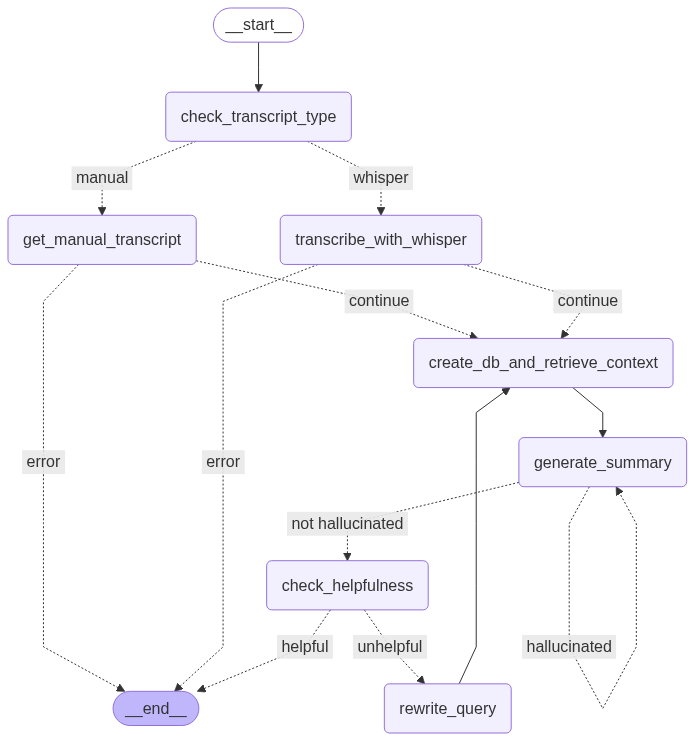

In [39]:
youtube_summarizer_agent

In [40]:
STATUS_MESSAGES = {
    "check_transcript_type": "영상 자막 유형을 확인하고 있습니다...",
    "get_manual_transcript": "수동 자막을 빠르게 가져오고 있습니다...",
    "transcribe_with_whisper": "Whisper 음성 인식을 시작합니다. (최대 5분 분량 처리)",
    "create_db_and_retrieve_context": "텍스트의 핵심 내용을 검색하고 있습니다...",
    "generate_summary": "검색된 내용을 바탕으로 최종 요약을 생성하고 있습니다...",
    "__end__": "모든 작업이 완료되었습니다!"
}

def run_agent_with_streaming_status(initial_state: dict):
    """에이전트를 실행하고 각 단계별 진행 상황을 스트리밍으로 반환합니다."""
    for s in youtube_summarizer_agent.stream(initial_state, {"recursion_limit": 10}):
        node_name = list(s.keys())[0]
        if node_name in STATUS_MESSAGES:
            yield f"[상태 업데이트] {STATUS_MESSAGES[node_name]}"
        if node_name == "__end__":
            yield s["__end__"]
            return

if __name__ == "__main__":
    # 테스트할 유튜브 URL
    # 수동 자막이 있는 영상 (빠른 경로 테스트용)
    url = "https://youtu.be/50WCSpZtdmA?si=SEY3D2aTGqLiGONL" # OpenAI DevDay
    
    # 수동 자막이 없는 영상 (Whisper 경로 테스트용)
    # url = "https://www.youtube.com/watch?v=eU4_N-L_pT4" # 다이소 화장품 추천영상

    initial_state = {
        'youtube_url': url,
        'query': '이 영상의 핵심 내용을 3가지로 요약해줘.'
    }

    print("===== 에이전트 실행 시작 =====")
    status_generator = run_agent_with_streaming_status(initial_state)

    final_result = None
    for status_update in status_generator:
        if isinstance(status_update, str):
            print(f"[{datetime.now().strftime('%H:%M:%S')}] {status_update}")
        else:
            final_result = status_update

    print("\n\n===== 최종 요약문 =====")
    if final_result and not final_result.get('error'):
        print(final_result.get('summary', '요약문을 찾을 수 없습니다.'))
    # final_result가 존재하지만 내부에 error가 있는 경우
    elif final_result and final_result.get('error'):
        print(f"오류가 발생했습니다: {final_result.get('error')}")
    # final_result가 None인 경우 (에이전트가 중간에 종료된 경우)
    else:
        print("에이전트가 예상치 못하게 종료되어 최종 결과가 없습니다. 위의 실행 로그를 확인해주세요.")


===== 에이전트 실행 시작 =====
1. [진단] yt-dlp를 사용해 'https://youtu.be/50WCSpZtdmA?si=SEY3D2aTGqLiGONL' 영상의 자막 유형 확인을 시작합니다.
--> [진단 결과] 수동 자막 가능성 높음! 'manual' 경로를 선택합니다. (en                     English, English, English, English, English, English, English, unknown vtt, srt, ttml, srv3, srv2, srv1, json3, vtt)
[12:20:05] [상태 업데이트] 영상 자막 유형을 확인하고 있습니다...
>>> 경로 선택: '빠른 경로(get_manual_transcript)' 노드가 성공적으로 실행되었습니다! <<<
[12:20:05] [상태 업데이트] 수동 자막을 빠르게 가져오고 있습니다...


===== 최종 요약문 =====
에이전트가 예상치 못하게 종료되어 최종 결과가 없습니다. 위의 실행 로그를 확인해주세요.


In [41]:
# # [이전 단계에서 정의한 모든 코드들: AgentState, 노드 함수, 그래프 빌더 등]
# # ...
# # youtube_summarizer_agent_faiss = graph_builder.compile()


# # --- Step 1: 상태 메시지 정의 ---
# STATUS_MESSAGES = {
#     "transcribe_audio": "음성 인식을 시작합니다... (영상 길이에 따라 시간이 걸릴 수 있습니다)",
#     "create_db_and_retrieve_context": "텍스트의 핵심 내용을 검색하고 있습니다...",
#     "generate_summary": "검색된 내용을 바탕으로 요약을 생성하고 있습니다...",
#     "rewrite_query": "더 나은 답변을 위해 질문을 수정하고 있습니다...",
#     "__end__": "모든 작업이 완료되었습니다!"
# }


# # --- Step 2: 스트리밍 출력을 위한 래퍼 함수 ---
# from datetime import datetime

# def run_agent_with_streaming_status(initial_state: dict):
#     """
#     에이전트를 실행하고 각 단계별 진행 상황을 스트리밍(yield)으로 반환하는 래퍼 함수.
#     """
#     for s in youtube_summarizer_agent_faiss.stream(initial_state, {"recursion_limit": 5}):
#         node_name = list(s.keys())[0]
        
#         if node_name in STATUS_MESSAGES:
#             yield f"[상태 업데이트] {STATUS_MESSAGES[node_name]}"
        
#         if node_name == "__end__":
#             yield s["__end__"]
#             return


# # --- Step 3: 새로운 래퍼 함수를 사용하여 에이전트 실행 ---
# if __name__ == "__main__":
#     youtube_url = "https://youtu.be/50WCSpZtdmA?si=1baiwisXm0O-57Z7"
#     initial_state = {
#         'youtube_url': youtube_url,
#         'query': '이 영상에서 어떤 부위 스트레칭을 알려줘?'
#     }

#     print("===== 에이전트 실행 시작 =====")
    
#     status_generator = run_agent_with_streaming_status(initial_state)

#     final_result = None
#     for status_update in status_generator:
#         if isinstance(status_update, str):
#             print(f"[{datetime.now().strftime('%H:%M:%S')}] {status_update}")
#         else:
#             final_result = status_update

#     print("\n\n===== 최종 요약문 =====")
#     if final_result and not final_result.get('error'):
#         print(final_result.get('summary', '요약문을 찾을 수 없습니다.'))
#     else:
#         print(f"오류가 발생했습니다: {final_result.get('error', '알 수 없는 오류')}")

## Agent 실행 및 시각화

In [42]:
# # Agent 실행
# youtube_url = "https://youtu.be/Oae2QogWa08?si=UuAKH1KLFF-2kf0W" # 예시: 다이소 화장품 추천영상
# initial_state = {
#     'youtube_url': youtube_url,
#     'query': '이 영상에서 추천하는 다이소 화장품과 그 이유는 뭐야?' # 구체적인 질문으로 변경
# }

# # 스트리밍 로그를 보며 실행
# for s in youtube_summarizer_agent_faiss.stream(initial_state, {"recursion_limit": 5}):
#     print(s)
#     print("---")

# # 최종 결과 확인
# final_state = youtube_summarizer_agent_faiss.invoke(initial_state, {"recursion_limit": 5})
# if not final_state.get('error'):
#     print("\n\n===== 최종 요약문 =====")
#     print(final_state['summary'])
# else:
#     print(f"\n\n===== 오류 발생 =====")
#     print(final_state['error'])